In [61]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GroupKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, f1_score
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import json, os, warnings
warnings.filterwarnings('ignore')

# ============================================================
# 可选依赖: Optuna / imblearn / LightGBM
# ============================================================
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    HAS_OPTUNA = True
    print("Optuna 已加载 ✓")
except ImportError:
    HAS_OPTUNA = False
    print("Optuna 未安装，将使用手动网格搜索")

try:
    from imblearn.over_sampling import SMOTE, BorderlineSMOTE
    HAS_IMBLEARN = True
    print("imbalanced-learn 已加载 ✓")
except ImportError:
    HAS_IMBLEARN = False
    print("imbalanced-learn 未安装，将使用 scale_pos_weight")

try:
    import lightgbm as lgb
    HAS_LGBM = True
    print("LightGBM 已加载 ✓")
except ImportError:
    HAS_LGBM = False
    print("LightGBM 未安装 (推荐: uv add lightgbm)")

print("\n依赖加载完毕 ✓")

Optuna 已加载 ✓
imbalanced-learn 已加载 ✓
LightGBM 未安装 (推荐: uv add lightgbm)

依赖加载完毕 ✓


In [62]:
# 1. 加载清洗后的数据
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"数据总行数: {len(df)}, 列数: {len(df.columns)}")
print(f"正样本占比: {df['is_spike_some'].mean():.4f}")

# 查看 source_file 分布
if 'source_file' in df.columns:
    print(f"\n各文件样本数:")
    print(df['source_file'].value_counts().to_string())

数据总行数: 4683, 列数: 74
正样本占比: 0.1001

各文件样本数:
source_file
psi_douyin_20260228_213146.csv    1241
psi_douyin_20260228_221442.csv    1225
psi_douyin_20260228_215103.csv    1220
psi_douyin_20260228_211328.csv     997


In [63]:
# 2. 定义目标变量 + 构造特征矩阵 + 两阶段特征筛选
y = df['is_spike_some']

# 保留 source_file 用于后续 GroupKFold 分组
groups = df['source_file'] if 'source_file' in df.columns else None

# 绝对不能让模型看到的列
cols_to_drop = [
    'future_1s_some', 'future_1s_full',
    'is_spike_some', 'is_spike_full',
    'source_file', 'ts'
]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
X = df.drop(columns=cols_to_drop)

print(f"原始特征数量: {len(X.columns)}")

# ========== 2a. 去除高相关冗余特征 (>0.95) ==========
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop_corr = set()
for col in upper.columns:
    highly_corr = upper.index[upper[col] > 0.95].tolist()
    if highly_corr:
        for hc in highly_corr:
            if hc not in to_drop_corr and col not in to_drop_corr:
                corr_with_y_col = abs(X[col].corr(y))
                corr_with_y_hc = abs(X[hc].corr(y))
                drop_feat = hc if corr_with_y_col >= corr_with_y_hc else col
                to_drop_corr.add(drop_feat)

if to_drop_corr:
    print(f"\n去除高相关冗余特征 ({len(to_drop_corr)} 个): {sorted(to_drop_corr)}")
    X = X.drop(columns=list(to_drop_corr))

print(f"相关性筛选后: {len(X.columns)} 个特征")

# ========== 2b. Mutual Information 特征筛选 (信息量驱动) ==========
print("\n计算 Mutual Information...")
mi_scores = mutual_info_classif(X.fillna(0), y, random_state=42, n_neighbors=5)
mi_df = pd.DataFrame({'feature': X.columns, 'mi': mi_scores}).sort_values('mi', ascending=False)

# 自适应阈值: 保留 MI > max_MI * 5% 的特征，最多 30 个
mi_threshold = mi_scores.max() * 0.05
important_by_mi = mi_df[mi_df['mi'] >= mi_threshold]['feature'].tolist()
MAX_FEATURES = 30
selected_features = mi_df.head(MAX_FEATURES)['feature'].tolist() if len(important_by_mi) > MAX_FEATURES else important_by_mi

dropped_mi = [c for c in X.columns if c not in selected_features]
if dropped_mi:
    print(f"MI 筛选掉 {len(dropped_mi)} 个低信息量特征")
    X = X[selected_features]

print(f"\nMI Top 30 特征:")
for i, row in mi_df.head(30).iterrows():
    marker = "✓" if row['feature'] in selected_features else "✗"
    print(f"  {marker} {row['feature']:30s}  MI={row['mi']:.5f}")

feature_names = X.columns.tolist()
print(f"\n最终特征数量: {len(feature_names)}")
print(f"标签分布:\n{y.value_counts()}")
print(f"正样本比例: {y.mean():.2%}")

原始特征数量: 69

去除高相关冗余特征 (15 个): ['full_mem_ratio', 'full_std_6', 'mem_available', 'mem_ewm_6', 'mem_lag_1', 'mem_lag_2', 'mem_lag_3', 'mem_lag_4', 'pgmaj_sum_6', 'pgmajfault', 'some_mean_6', 'some_mem_ratio', 'some_range_6', 'some_std_6', 'some_sum_6']
相关性筛选后: 54 个特征

计算 Mutual Information...
MI 筛选掉 24 个低信息量特征

MI Top 30 特征:
  ✓ full_max_6                      MI=0.08947
  ✓ some_max_6                      MI=0.08603
  ✓ allocstall                      MI=0.07810
  ✓ alloc_pgscan_ratio              MI=0.07414
  ✓ pswpout                         MI=0.06782
  ✓ some_delta                      MI=0.06507
  ✓ full_delta                      MI=0.06262
  ✓ mem_min_6                       MI=0.06160
  ✓ pgscan_sum_10                   MI=0.06111
  ✓ some_ewm_6                      MI=0.06001
  ✓ workingset_refault              MI=0.05993
  ✓ pgscan_sum_6                    MI=0.05951
  ✓ full_sum_2                      MI=0.05950
  ✓ some_sum_2                      MI=0.05921
  ✓ diff_some    

In [64]:
# 3. 按会话边界切分 (杜绝同一会话内数据泄漏)
PURGE_GAP = 12

if groups is not None:
    # 找到完整会话的累计边界
    session_sizes = groups.value_counts(sort=False)
    session_order = groups.drop_duplicates().values  # 保持原始顺序
    cumulative = 0
    boundaries = {}
    for s in session_order:
        cumulative += session_sizes[s]
        boundaries[s] = cumulative

    # 选择最接近 75% 的会话边界作为切分点 (完整会话)
    target_split = int(len(X) * 0.75)
    best_session = min(boundaries, key=lambda s: abs(boundaries[s] - target_split))
    split_idx = boundaries[best_session]

    train_sessions = []
    for s in session_order:
        train_sessions.append(s)
        if s == best_session:
            break
    test_sessions = [s for s in session_order if s not in train_sessions]

    train_mask = groups.isin(train_sessions)
    test_mask = groups.isin(test_sessions)

    X_train = X[train_mask].copy()
    y_train = y[train_mask].copy()
    X_test = X[test_mask].copy()
    y_test = y[test_mask].copy()
    groups_train = groups[train_mask]

    print(f"会话级切分:")
    print(f"  训练会话: {train_sessions}")
    print(f"  测试会话: {test_sessions}")
else:
    # 回退: 按比例切分 + purge gap
    split_point = int(len(X) * 0.8)
    X_train = X.iloc[:split_point - PURGE_GAP]
    y_train = y.iloc[:split_point - PURGE_GAP]
    X_test = X.iloc[split_point:]
    y_test = y.iloc[split_point:]
    groups_train = None

negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
spw = negative_count / positive_count

print(f"\n训练集: {len(X_train)} 行, 测试集: {len(X_test)} 行")
print(f"训练集 — 负样本: {negative_count}, 正样本: {positive_count}")
print(f"scale_pos_weight: {spw:.2f}")
print(f"训练集正样本比例: {y_train.mean():.2%}")
print(f"测试集正样本比例: {y_test.mean():.2%}")

会话级切分:
  训练会话: ['psi_douyin_20260228_211328.csv', 'psi_douyin_20260228_213146.csv', 'psi_douyin_20260228_215103.csv']
  测试会话: ['psi_douyin_20260228_221442.csv']

训练集: 3458 行, 测试集: 1225 行
训练集 — 负样本: 3094, 正样本: 364
scale_pos_weight: 8.50
训练集正样本比例: 10.53%
测试集正样本比例: 8.57%


In [65]:
# 4. 定义过采样辅助函数 (在 Optuna 内部按需调用)
# V4: 不再提前做 1:1 SMOTE，由 Optuna 选择最佳策略

def apply_oversampling(X_in, y_in, strategy='none', ratio=0.3, seed=42):
    """
    strategy:
      'none'    — 不过采样，使用 scale_pos_weight
      'partial' — SMOTE ratio=0.3 (少数样本达到多数的 30%)
      'full'    — SMOTE ratio=1.0 (完全平衡)
    """
    if strategy == 'none':
        return X_in, y_in

    if HAS_IMBLEARN:
        try:
            sm = BorderlineSMOTE(
                sampling_strategy=ratio if strategy == 'partial' else 1.0,
                random_state=seed, k_neighbors=min(5, (y_in == 1).sum() - 1)
            )
            X_res, y_res = sm.fit_resample(X_in, y_in)
            return X_res, y_res
        except Exception as e:
            print(f"  SMOTE 失败 ({e}), 回退到无过采样")
            return X_in, y_in
    else:
        # 手动复制+噪声
        pos = X_in[y_in == 1]
        n_target = int((y_in == 0).sum() * ratio) - (y_in == 1).sum()
        if n_target <= 0:
            return X_in, y_in
        n_copies = max(1, n_target // len(pos))
        aug_X, aug_y = [], []
        for _ in range(n_copies):
            noise = np.random.normal(0, 0.01, pos.shape) * pos.std().values
            aug_X.append(pos + noise)
            aug_y.append(y_in[y_in == 1])
        return (pd.concat([X_in] + aug_X, ignore_index=True),
                pd.concat([y_in] + aug_y, ignore_index=True))

# 预览各策略效果
for strat in ['none', 'partial', 'full']:
    X_tmp, y_tmp = apply_oversampling(X_train, y_train, strategy=strat)
    pos_n = (y_tmp == 1).sum()
    neg_n = (y_tmp == 0).sum()
    print(f"  {strat:8s}: {len(y_tmp):5d} 行, 正/负={pos_n}/{neg_n}, 比例={pos_n/(neg_n+1):.2f}")

  none    :  3458 行, 正/负=364/3094, 比例=0.12
  partial :  4022 行, 正/负=928/3094, 比例=0.30
  full    :  6188 行, 正/负=3094/3094, 比例=1.00


In [66]:
# 5. 超参搜索 (Optuna: 模型类型 + 过采样策略 + 正则化参数)
# ============================================================
# V4: GroupKFold 按会话分组、过采样策略可选、XGB+LGBM 双模型
# ============================================================
def focal_loss_objective(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Focal loss for XGBClassifier sklearn API."""
    p = 1.0 / (1.0 + np.exp(-y_pred))
    focal_weight = alpha * y_true * (1 - p)**gamma + (1 - alpha) * (1 - y_true) * p**gamma
    grad = focal_weight * (p - y_true)
    hess = focal_weight * p * (1 - p)
    hess = np.maximum(hess, 1e-6)
    return grad, hess

# GroupKFold: 每个 fold 完整排除一个会话 → 最公平的泛化评估
if groups_train is not None:
    unique_groups = groups_train.unique()
    n_groups = len(unique_groups)
    cv_splitter = GroupKFold(n_splits=min(n_groups, 4))
    cv_groups = groups_train.values
    print(f"使用 GroupKFold (按 {n_groups} 个会话分组)")
else:
    cv_splitter = TimeSeriesSplit(n_splits=4, gap=PURGE_GAP)
    cv_groups = None
    print("使用 TimeSeriesSplit")

if HAS_OPTUNA:
    def objective(trial):
        # ========== 过采样策略 ==========
        sampling_strategy = trial.suggest_categorical('sampling', ['none', 'partial', 'full'])
        
        # ========== 模型类型 ==========
        model_type = trial.suggest_categorical('model_type', 
                                                ['xgb', 'lgbm'] if HAS_LGBM else ['xgb'])
        
        if model_type == 'xgb':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
                'max_depth': trial.suggest_int('max_depth', 2, 5),
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.08, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 10, 80),
                'gamma': trial.suggest_float('gamma', 0.1, 2.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 30.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.4, 0.8),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 8),
            }
        else:  # lgbm
            params = {
                'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 1200),
                'max_depth': trial.suggest_int('lgb_max_depth', 2, 5),
                'learning_rate': trial.suggest_float('lgb_lr', 0.005, 0.08, log=True),
                'min_child_samples': trial.suggest_int('lgb_min_child', 20, 100),
                'reg_alpha': trial.suggest_float('lgb_alpha', 0.1, 20.0, log=True),
                'reg_lambda': trial.suggest_float('lgb_lambda', 1.0, 30.0, log=True),
                'subsample': trial.suggest_float('lgb_subsample', 0.4, 0.8),
                'colsample_bytree': trial.suggest_float('lgb_colsample', 0.3, 0.8),
                'num_leaves': trial.suggest_int('lgb_num_leaves', 8, 31),
                'min_split_gain': trial.suggest_float('lgb_min_gain', 0.1, 2.0),
            }
        
        fold_aps = []
        if cv_groups is not None:
            split_iter = cv_splitter.split(X_train, y_train, cv_groups)
        else:
            split_iter = cv_splitter.split(X_train)
        
        for tr_idx, va_idx in split_iter:
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train.iloc[tr_idx]
            y_va = y_train.iloc[va_idx]
            
            # 按 Optuna 选择的策略做过采样
            X_tr_r, y_tr_r = apply_oversampling(X_tr, y_tr, strategy=sampling_strategy)
            
            # 计算当前 fold 的类别比
            fold_spw = (y_tr_r == 0).sum() / max((y_tr_r == 1).sum(), 1)
            
            if model_type == 'xgb':
                clf = xgb.XGBClassifier(
                    **params,
                    scale_pos_weight=fold_spw if sampling_strategy == 'none' else 1.0,
                    eval_metric='aucpr',
                    early_stopping_rounds=50,
                    random_state=42, n_jobs=-1, verbosity=0
                )
                clf.fit(X_tr_r, y_tr_r, eval_set=[(X_va, y_va)], verbose=False)
            else:
                clf = lgb.LGBMClassifier(
                    **params,
                    scale_pos_weight=fold_spw if sampling_strategy == 'none' else 1.0,
                    metric='average_precision',
                    random_state=42, n_jobs=-1, verbose=-1
                )
                callbacks = [lgb.early_stopping(50, verbose=False), lgb.log_evaluation(-1)]
                clf.fit(X_tr_r, y_tr_r, eval_set=[(X_va, y_va)], callbacks=callbacks)
            
            y_va_proba = clf.predict_proba(X_va)[:, 1]
            fold_aps.append(average_precision_score(y_va, y_va_proba))
        
        return np.mean(fold_aps)
    
    study = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(seed=42))
    print("开始 Optuna 贝叶斯超参搜索 (80 trials)...")
    study.optimize(objective, n_trials=80, show_progress_bar=True)
    
    best_trial = study.best_trial
    best_model_type = best_trial.params.get('model_type', 'xgb')
    best_sampling = best_trial.params.get('sampling', 'none')
    
    # 提取对应模型的参数
    skip_keys = {'sampling', 'model_type'}
    if best_model_type == 'lgbm':
        skip_keys.update({'n_estimators', 'max_depth', 'learning_rate', 'min_child_weight',
                          'gamma', 'reg_alpha', 'reg_lambda', 'subsample', 'colsample_bytree',
                          'colsample_bylevel', 'max_delta_step'})
        # Rename lgb_ prefixed params
        best_params = {}
        for k, v in best_trial.params.items():
            if k.startswith('lgb_'):
                name_map = {'lgb_n_estimators': 'n_estimators', 'lgb_max_depth': 'max_depth',
                            'lgb_lr': 'learning_rate', 'lgb_min_child': 'min_child_samples',
                            'lgb_alpha': 'reg_alpha', 'lgb_lambda': 'reg_lambda',
                            'lgb_subsample': 'subsample', 'lgb_colsample': 'colsample_bytree',
                            'lgb_num_leaves': 'num_leaves', 'lgb_min_gain': 'min_split_gain'}
                best_params[name_map.get(k, k)] = v
    else:
        best_params = {k: v for k, v in best_trial.params.items() if k not in skip_keys and not k.startswith('lgb_')}

    print(f"\n✓ 最优 CV AP: {study.best_value:.4f}")
    print(f"  模型类型: {best_model_type}")
    print(f"  过采样策略: {best_sampling}")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

else:
    # ========== 手动网格搜索 (保守参数 + 不同过采样策略) ==========
    param_candidates = [
        {"n_estimators": 800, "max_depth": 3, "learning_rate": 0.01,
         "min_child_weight": 20, "gamma": 0.5, "reg_alpha": 2.0, "reg_lambda": 15,
         "subsample": 0.6, "colsample_bytree": 0.5},
        {"n_estimators": 600, "max_depth": 3, "learning_rate": 0.02,
         "min_child_weight": 30, "gamma": 0.8, "reg_alpha": 5.0, "reg_lambda": 10,
         "subsample": 0.55, "colsample_bytree": 0.45},
        {"n_estimators": 1000, "max_depth": 2, "learning_rate": 0.01,
         "min_child_weight": 40, "gamma": 0.3, "reg_alpha": 1.0, "reg_lambda": 20,
         "subsample": 0.7, "colsample_bytree": 0.6},
    ]
    
    best_score = -1
    best_params = None
    best_sampling = 'none'
    best_model_type = 'xgb'

    print("开始手动网格搜索...")
    for i, params in enumerate(param_candidates):
        for sampling in ['none', 'partial']:
            fold_scores = []
            if cv_groups is not None:
                split_iter = cv_splitter.split(X_train, y_train, cv_groups)
            else:
                split_iter = cv_splitter.split(X_train)
            for tr_idx, va_idx in split_iter:
                X_tr = X_train.iloc[tr_idx]; y_tr = y_train.iloc[tr_idx]
                X_va = X_train.iloc[va_idx]; y_va = y_train.iloc[va_idx]
                X_tr_r, y_tr_r = apply_oversampling(X_tr, y_tr, strategy=sampling)
                fold_spw = (y_tr_r == 0).sum() / max((y_tr_r == 1).sum(), 1)
                clf = xgb.XGBClassifier(
                    **params, scale_pos_weight=fold_spw if sampling == 'none' else 1.0,
                    eval_metric='aucpr', early_stopping_rounds=50,
                    random_state=42, n_jobs=-1, verbosity=0)
                clf.fit(X_tr_r, y_tr_r, eval_set=[(X_va, y_va)], verbose=False)
                fold_scores.append(average_precision_score(y_va, clf.predict_proba(X_va)[:, 1]))
            mean_ap = np.mean(fold_scores)
            print(f"  组{i+1}+{sampling}: AP={mean_ap:.4f}")
            if mean_ap > best_score:
                best_score = mean_ap
                best_params = params
                best_sampling = sampling

    print(f"\n✓ 最优 (CV AP={best_score:.4f}, sampling={best_sampling})")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

使用 GroupKFold (按 3 个会话分组)
开始 Optuna 贝叶斯超参搜索 (80 trials)...


Best trial: 64. Best value: 0.553413: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]


✓ 最优 CV AP: 0.5534
  模型类型: xgb
  过采样策略: none
  n_estimators: 1076
  max_depth: 3
  learning_rate: 0.062408344068915815
  min_child_weight: 20
  gamma: 0.6166610610412018
  reg_alpha: 0.1275696097046671
  reg_lambda: 1.980950753517497
  subsample: 0.6325483982452645
  colsample_bytree: 0.4439269787619981
  colsample_bylevel: 0.9766209151608976
  max_delta_step: 7


In [67]:
# 6. 正式训练 (Bagged Ensemble: 多种子 + Optuna 最优过采样策略)
N_BAGS = 5
bag_models = []

# 按最优策略准备训练数据
X_train_res, y_train_res = apply_oversampling(X_train, y_train, strategy=best_sampling)
spw_final = (y_train_res == 0).sum() / max((y_train_res == 1).sum(), 1)

print(f"训练配置: model={best_model_type}, sampling={best_sampling}")
print(f"训练数据: {len(X_train_res)} 行, spw={spw_final:.2f}")

for seed in range(N_BAGS):
    if best_model_type == 'lgbm' and HAS_LGBM:
        clf = lgb.LGBMClassifier(
            **best_params,
            scale_pos_weight=spw_final if best_sampling == 'none' else 1.0,
            metric='average_precision',
            random_state=seed * 7 + 42,
            n_jobs=-1, verbose=-1
        )
        callbacks = [lgb.early_stopping(50, verbose=False), lgb.log_evaluation(-1)]
        clf.fit(
            X_train_res, y_train_res,
            eval_set=[(X_train_res, y_train_res), (X_test, y_test)],
            callbacks=callbacks
        )
        best_iter = clf.best_iteration_
    else:
        clf = xgb.XGBClassifier(
            **best_params,
            scale_pos_weight=spw_final if best_sampling == 'none' else 1.0,
            eval_metric='aucpr',
            early_stopping_rounds=50,
            random_state=seed * 7 + 42,
            n_jobs=-1, verbosity=0
        )
        clf.fit(
            X_train_res, y_train_res,
            eval_set=[(X_train_res, y_train_res), (X_test, y_test)],
            verbose=False
        )
        best_iter = clf.best_iteration

    bag_models.append(clf)
    test_ap = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"Bag {seed+1}: best_iter={best_iter}, test AP={test_ap:.4f}")

# ========== 集成预测 ==========
y_probas = np.column_stack([m.predict_proba(X_test)[:, 1] for m in bag_models])
y_proba = y_probas.mean(axis=1)

roc_auc = roc_auc_score(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

y_pred = (y_proba > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

print(f"\n=== Bagged Ensemble ({N_BAGS} models) 测试集表现 ===")
print(f"模型: {best_model_type}, 过采样: {best_sampling}")
print(f"               预测平稳(0)  预测卡顿(1)")
print(f"实际平稳(0):      {cm[0][0]}          {cm[0][1]}  (误报)")
print(f"实际卡顿(1):      {cm[1][0]}  (漏报)   {cm[1][1]}")
print(f"\n{classification_report(y_test, y_pred)}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {ap_score:.4f}")

# 第一个模型用于单模分析
clf_some = bag_models[0]

训练配置: model=xgb, sampling=none
训练数据: 3458 行, spw=8.50
Bag 1: best_iter=124, test AP=0.4931
Bag 2: best_iter=151, test AP=0.5001
Bag 3: best_iter=81, test AP=0.5051
Bag 4: best_iter=11, test AP=0.4884
Bag 5: best_iter=115, test AP=0.5006

=== Bagged Ensemble (5 models) 测试集表现 ===
模型: xgb, 过采样: none
               预测平稳(0)  预测卡顿(1)
实际平稳(0):      998          122  (误报)
实际卡顿(1):      43  (漏报)   62

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1120
           1       0.34      0.59      0.43       105

    accuracy                           0.87      1225
   macro avg       0.65      0.74      0.68      1225
weighted avg       0.91      0.87      0.88      1225

ROC-AUC: 0.8195
PR-AUC (Average Precision): 0.5028


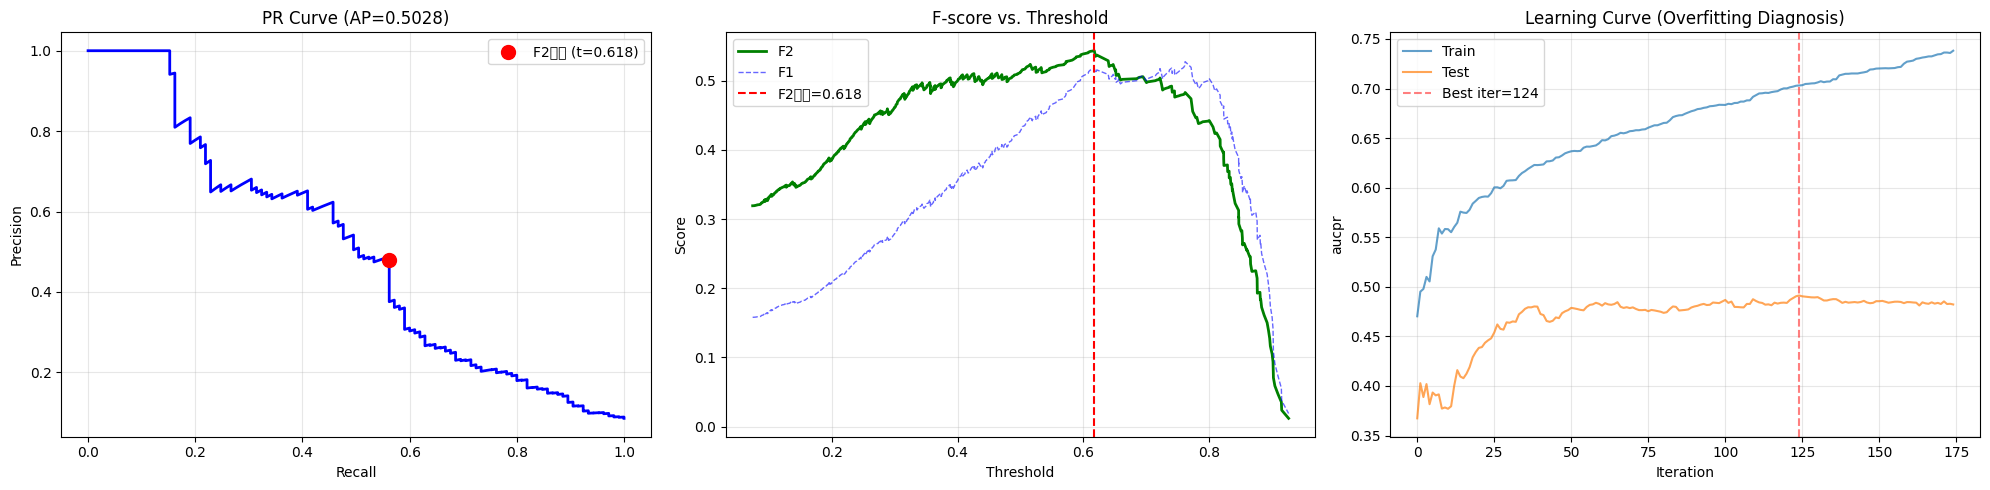


✓ F2-最优阈值: 0.6176
  Precision=0.4797, Recall=0.5619, F2=0.5433
  (对比) F1-最优阈值: 0.7620

=== F2-最优阈值 (0.6176) 后的表现 ===
               预测平稳(0)  预测卡顿(1)
实际平稳(0):      1056          64  (误报)
实际卡顿(1):      47  (漏报)   58

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1120
           1       0.48      0.55      0.51       105

    accuracy                           0.91      1225
   macro avg       0.72      0.75      0.73      1225
weighted avg       0.92      0.91      0.91      1225


=== 各会话测试表现 ===
  psi_douyin_20260228_221442.csv: AP=0.5028, 正样本率=8.57%, n=1225


In [68]:
# 7. PR 曲线 + 自动最优阈值 + 学习曲线诊断
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ========== 左图: PR 曲线 ==========
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f2_scores = []
for p, r in zip(precisions[:-1], recalls[:-1]):
    f2 = (5 * p * r / (4 * p + r)) if (p + r > 0) else 0
    f2_scores.append(f2)
f1_scores_arr = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-8)

best_f2_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_f2_idx]
best_f2 = f2_scores[best_f2_idx]
best_p = precisions[best_f2_idx]
best_r = recalls[best_f2_idx]

f1_best_idx = np.argmax(f1_scores_arr)
f1_best_threshold = thresholds[f1_best_idx]

axes[0].plot(recalls, precisions, 'b-', linewidth=2)
axes[0].scatter([best_r], [best_p], c='red', s=100, zorder=5, label=f'F2最优 (t={best_threshold:.3f})')
axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision')
axes[0].set_title(f'PR Curve (AP={ap_score:.4f})')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# ========== 中图: F-score vs. 阈值 ==========
axes[1].plot(thresholds, f2_scores, 'g-', linewidth=2, label='F2')
axes[1].plot(thresholds, f1_scores_arr, 'b--', linewidth=1, alpha=0.6, label='F1')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'F2最优={best_threshold:.3f}')
axes[1].set_xlabel('Threshold'); axes[1].set_ylabel('Score')
axes[1].set_title('F-score vs. Threshold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

# ========== 右图: 学习曲线 (诊断过拟合) ==========
try:
    if best_model_type == 'lgbm' and HAS_LGBM:
        results = clf_some.evals_result_
        train_key = list(results.keys())[0]
        test_key = list(results.keys())[1] if len(results) > 1 else None
        metric_key = list(results[train_key].keys())[0]
        axes[2].plot(results[train_key][metric_key], label='Train', alpha=0.7)
        if test_key:
            axes[2].plot(results[test_key][metric_key], label='Test', alpha=0.7)
        best_it = clf_some.best_iteration_
    else:
        results = clf_some.evals_result()
        metric_key = list(results['validation_0'].keys())[0]
        axes[2].plot(results['validation_0'][metric_key], label='Train', alpha=0.7)
        if 'validation_1' in results:
            axes[2].plot(results['validation_1'][metric_key], label='Test', alpha=0.7)
        best_it = clf_some.best_iteration
    axes[2].axvline(x=best_it, color='red', linestyle='--', alpha=0.5, label=f'Best iter={best_it}')
except Exception as e:
    axes[2].text(0.5, 0.5, f'学习曲线不可用\n{e}', transform=axes[2].transAxes, ha='center')

axes[2].set_xlabel('Iteration'); axes[2].set_ylabel(metric_key if 'metric_key' in dir() else 'metric')
axes[2].set_title('Learning Curve (Overfitting Diagnosis)')
axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ F2-最优阈值: {best_threshold:.4f}")
print(f"  Precision={best_p:.4f}, Recall={best_r:.4f}, F2={best_f2:.4f}")
print(f"  (对比) F1-最优阈值: {f1_best_threshold:.4f}")

# ========== 用最优阈值重新评估 ==========
y_pred_opt = (y_proba > best_threshold).astype(int)
print(f"\n=== F2-最优阈值 ({best_threshold:.4f}) 后的表现 ===")
cm_opt = confusion_matrix(y_test, y_pred_opt)
print(f"               预测平稳(0)  预测卡顿(1)")
print(f"实际平稳(0):      {cm_opt[0][0]}          {cm_opt[0][1]}  (误报)")
print(f"实际卡顿(1):      {cm_opt[1][0]}  (漏报)   {cm_opt[1][1]}")
print(f"\n{classification_report(y_test, y_pred_opt)}")

# ========== 各会话单独评估 (检查泛化一致性) ==========
if groups is not None:
    test_groups = groups[y_test.index]
    print("\n=== 各会话测试表现 ===")
    for session in test_groups.unique():
        mask = test_groups == session
        if mask.sum() > 10 and y_test[mask].sum() > 0:
            sess_ap = average_precision_score(y_test[mask], y_proba[mask])
            sess_pos_rate = y_test[mask].mean()
            print(f"  {session}: AP={sess_ap:.4f}, 正样本率={sess_pos_rate:.2%}, n={mask.sum()}")

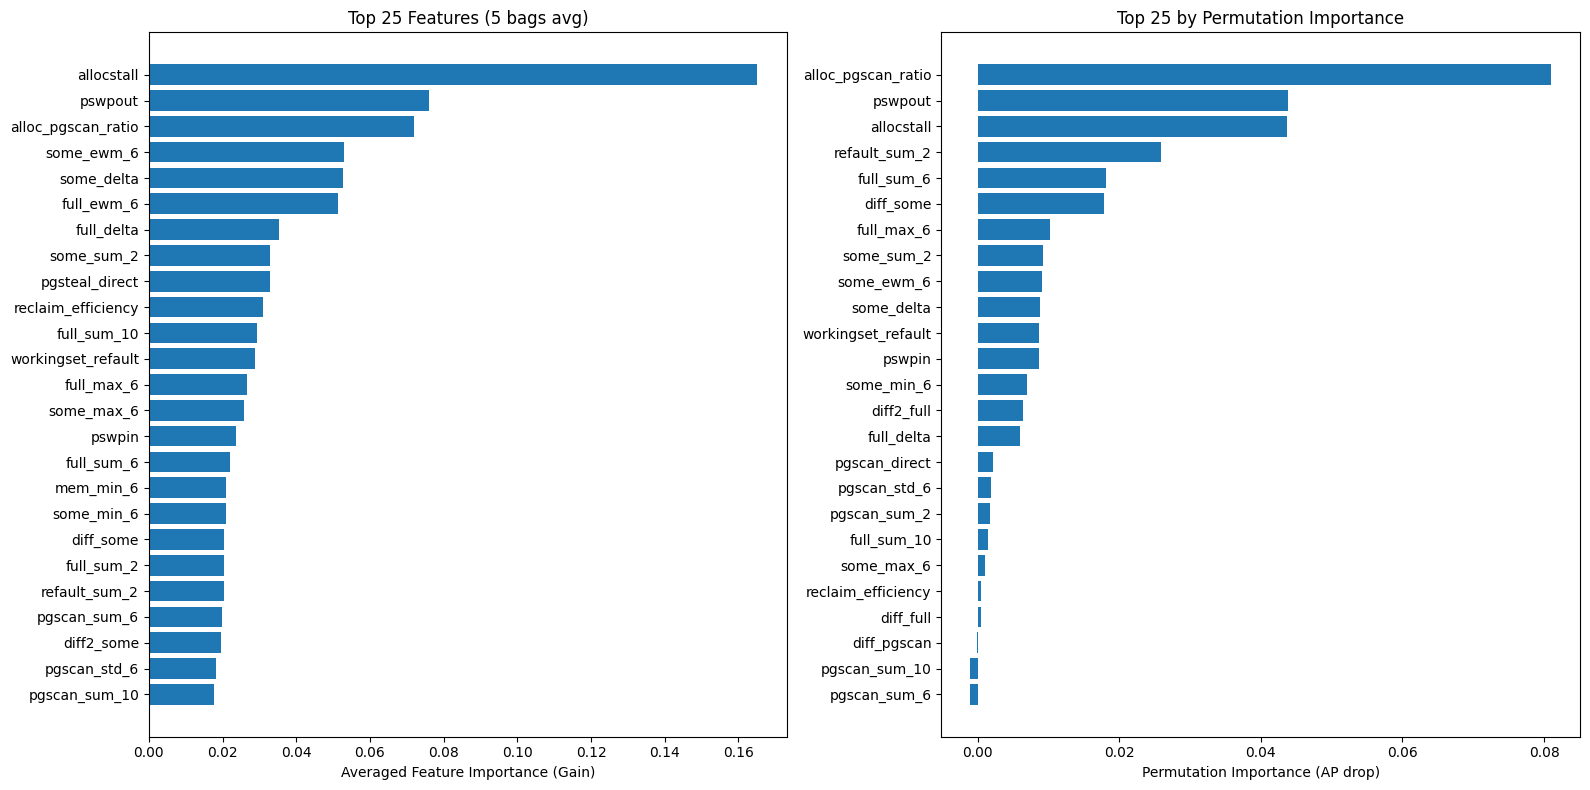

Permutation 为负 (噪声特征): ['mem_min_6', 'pgscan_sum_10', 'pgscan_sum_6', 'full_sum_2', 'full_ewm_6', 'diff_pgscan', 'pgsteal_direct', 'diff2_some']


In [69]:
# 8. 特征重要性 + Permutation Importance (更可靠)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ========== 左图: 平均 Gain 重要性 ==========
all_importances = np.zeros(len(feature_names))
for m in bag_models:
    all_importances += m.feature_importances_
all_importances /= len(bag_models)

sorted_idx = all_importances.argsort()
top_n = min(25, len(sorted_idx))

axes[0].barh(
    np.array(feature_names)[sorted_idx[-top_n:]],
    all_importances[sorted_idx[-top_n:]]
)
axes[0].set_xlabel("Averaged Feature Importance (Gain)")
axes[0].set_title(f"Top {top_n} Features ({N_BAGS} bags avg)")

# ========== 右图: Permutation Importance (不受特征尺度影响) ==========
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(
    bag_models[0], X_test, y_test,
    n_repeats=10, random_state=42,
    scoring='average_precision',
    n_jobs=-1
)
perm_sorted_idx = perm_result.importances_mean.argsort()
axes[1].barh(
    np.array(feature_names)[perm_sorted_idx[-top_n:]],
    perm_result.importances_mean[perm_sorted_idx[-top_n:]]
)
axes[1].set_xlabel("Permutation Importance (AP drop)")
axes[1].set_title(f"Top {top_n} by Permutation Importance")

plt.tight_layout()
plt.show()

# ========== 显示近零重要性特征 ==========
zero_feats = [feature_names[i] for i in range(len(feature_names)) if all_importances[i] < 0.005]
if zero_feats:
    print(f"\n近零重要性特征 ({len(zero_feats)} 个，可考虑删除): {zero_feats}")

# Permutation 重要性为负的特征 = 噪声
neg_perm = [feature_names[i] for i in range(len(feature_names))
            if perm_result.importances_mean[i] < 0]
if neg_perm:
    print(f"Permutation 为负 (噪声特征): {neg_perm}")

In [70]:
# 9. 导出模型和配置
os.makedirs("../model", exist_ok=True)

# 保存模型
if best_model_type == 'xgb':
    clf_some.save_model("../model/xgb_some.json")
    for i, m in enumerate(bag_models):
        m.save_model(f"../model/xgb_some_bag{i}.json")
    print("✓ XGBoost 模型已保存 (JSON)")
elif best_model_type == 'lgbm' and HAS_LGBM:
    clf_some.booster_.save_model("../model/lgbm_some.txt")
    for i, m in enumerate(bag_models):
        m.booster_.save_model(f"../model/lgbm_some_bag{i}.txt")
    print("✓ LightGBM 模型已保存 (TXT)")

# 保存特征列表
with open("../model/feature_cols.json", "w") as f:
    json.dump(feature_names, f, indent=2)

# 保存最优阈值和训练元信息
meta = {
    "model_type": best_model_type,
    "threshold_f2_optimal": float(best_threshold),
    "threshold_f1_optimal": float(f1_best_threshold),
    "best_params": {k: (float(v) if isinstance(v, (np.floating, float)) else int(v) if isinstance(v, (np.integer, int)) else v) for k, v in best_params.items()},
    "sampling_strategy": best_sampling,
    "n_bags": N_BAGS,
    "scale_pos_weight": float(spw),
    "purge_gap": PURGE_GAP,
    "train_rows": len(X_train),
    "train_rows_resampled": len(X_train_res),
    "test_rows": len(X_test),
    "n_features": len(feature_names),
    "feature_names": feature_names,
    "test_roc_auc": float(roc_auc),
    "test_pr_auc": float(ap_score),
}
with open("../model/model_meta.json", "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f"  - model/feature_cols.json ({len(feature_names)} 个特征)")
print(f"  - model/model_meta.json")
print(f"\n=== V4 性能汇总 ===")
print(f"  模型: {best_model_type}")
print(f"  过采样: {best_sampling}")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC:  {ap_score:.4f}")
print(f"  F2-最优阈值: {best_threshold:.4f}")
print(f"  (Recall={best_r:.4f}, Precision={best_p:.4f})")

✓ XGBoost 模型已保存 (JSON)
  - model/feature_cols.json (30 个特征)
  - model/model_meta.json

=== V4 性能汇总 ===
  模型: xgb
  过采样: none
  ROC-AUC: 0.8195
  PR-AUC:  0.5028
  F2-最优阈值: 0.6176
  (Recall=0.5619, Precision=0.4797)
